In [1]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder,MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,save_model
from keras.layers.convolutional import  Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from IPython.display import Audio
from keras.layers.core import  Dense, Flatten, Dropout,Activation

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
crema_data='/content/drive/MyDrive/speech/Crema'
ravdess_data='/content/drive/MyDrive/speech/Ravdess/audio_speech_actors_01-24'
savee_data='/content/drive/MyDrive/speech/Savee'
tess_data='/content/drive/MyDrive/speech/Tess'

###1. Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). 

NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

###03-01-08-02-02-02-01.wav

03 = audio-only

01 = speech

 08 = surprised

 02 = "Dogs are sitting by the door"

 02 = 2nd repetition

 01 = male actor

In [70]:

ravdess_directory_list = os.listdir(ravdess_data)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess_data + '/' + dir)
    
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess_data + '/' + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions .replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,/content/drive/MyDrive/speech/Ravdess/audio_sp...
1,neutral,/content/drive/MyDrive/speech/Ravdess/audio_sp...
2,neutral,/content/drive/MyDrive/speech/Ravdess/audio_sp...
3,neutral,/content/drive/MyDrive/speech/Ravdess/audio_sp...
4,neutral,/content/drive/MyDrive/speech/Ravdess/audio_sp...


In [71]:
crema_directory_list = os.listdir(crema_data)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(crema_data +'/'+ file)
    # storing file emotions
    part=file.split('_')
    # if part[0] == 1001:
    #     gender='male_'
    # else:
    #     gender='female_'

    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,happy,/content/drive/MyDrive/speech/Crema/1080_DFA_H...
1,disgust,/content/drive/MyDrive/speech/Crema/1080_IEO_D...
2,sad,/content/drive/MyDrive/speech/Crema/1080_WSI_S...
3,angry,/content/drive/MyDrive/speech/Crema/1080_TAI_A...
4,happy,/content/drive/MyDrive/speech/Crema/1080_MTI_H...


In [72]:
tess_directory_list = os.listdir(tess_data)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(tess_data + '/' + dir)
    # gender=dir.split('_')[0]
    # if gender=='OAF':
    #     gender='male_'
    # else:
    #     gender='female_'
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(tess_data + '/' + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head(20)

,Emotions,Path
0,fear,/content/drive/MyDrive/speech/Tess/YAF_fear/YA...
1,fear,/content/drive/MyDrive/speech/Tess/YAF_fear/YA...
2,fear,/content/drive/MyDrive/speech/Tess/YAF_fear/YA...
3,fear,/content/drive/MyDrive/speech/Tess/YAF_fear/YA...
4,fear,/content/drive/MyDrive/speech/Tess/YAF_fear/YA...
5,fear,/content/drive/MyDrive/speech/Tess/YAF_fear/YA...
6,fear,/content/drive/MyDrive/speech/Tess/YAF_fear/YA...
7,fear,/content/drive/MyDrive/speech/Tess/YAF_fear/YA...
8,fear,/content/drive/MyDrive/speech/Tess/YAF_fear/YA...
9,fear,/content/drive/MyDrive/speech/Tess/YAF_fear/YA...


###4. CREMA_DATA dataset
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

'a' = 'anger'
'd' = 'disgust'
'f' = 'fear'
'h' = 'happiness'
'n' = 'neutral'
'sa' = 'sadness'
'su' = 'surprise'

In [73]:
savee_directory_list = os.listdir(savee_data)

file_emotion = []
file_path = []
#gender='male_'

for file in savee_directory_list:
    file_path.append(savee_data + '/' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/speech/Savee/DC_a09.wav
1,angry,/content/drive/MyDrive/speech/Savee/DC_a05.wav
2,angry,/content/drive/MyDrive/speech/Savee/DC_a07.wav
3,angry,/content/drive/MyDrive/speech/Savee/DC_a06.wav
4,angry,/content/drive/MyDrive/speech/Savee/DC_a10.wav


In [74]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Savee_df,Ravdess_df,Crema_df, Tess_df,], axis = 0) #,Crema_df, Tess_df, Savee_df
data_path.to_csv("data_path.csv",index=False)

data_path.shape

(12162, 2)

In [75]:
data_path.head()

,Emotions,Path
0,angry,/content/drive/MyDrive/speech/Savee/DC_a09.wav
1,angry,/content/drive/MyDrive/speech/Savee/DC_a05.wav
2,angry,/content/drive/MyDrive/speech/Savee/DC_a07.wav
3,angry,/content/drive/MyDrive/speech/Savee/DC_a06.wav
4,angry,/content/drive/MyDrive/speech/Savee/DC_a10.wav


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


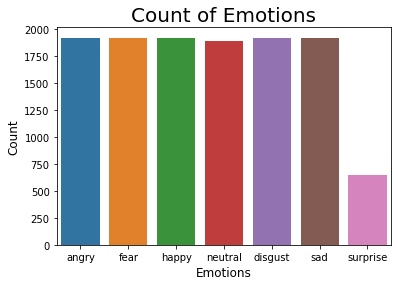

In [76]:
plt.title('Count of Emotions', size=20)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.show()

In [77]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

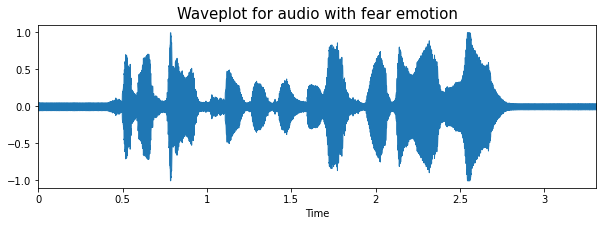

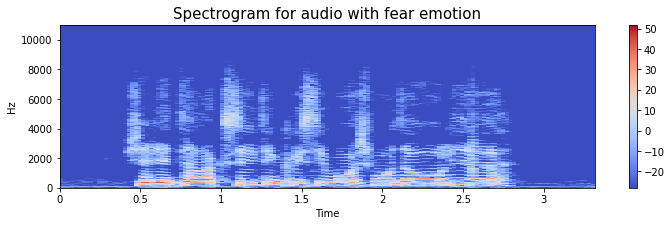

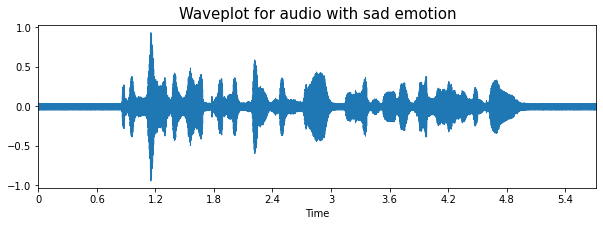

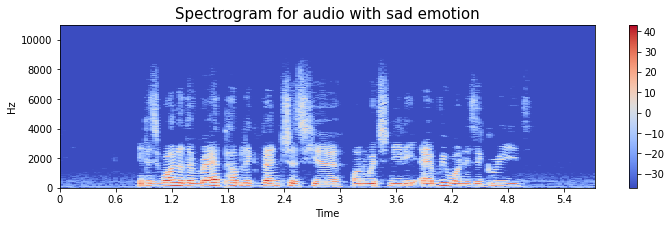

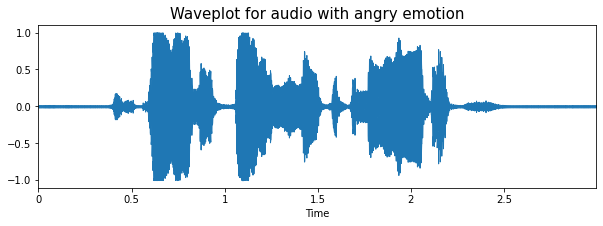

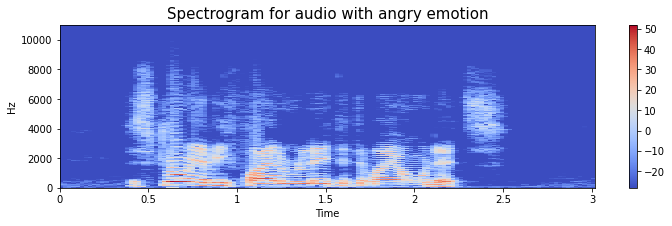

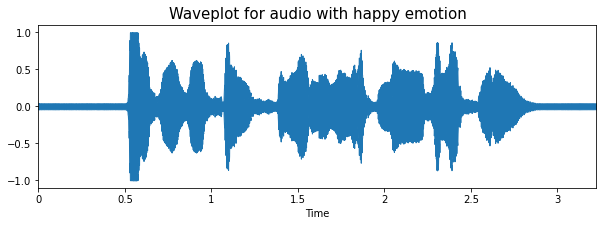

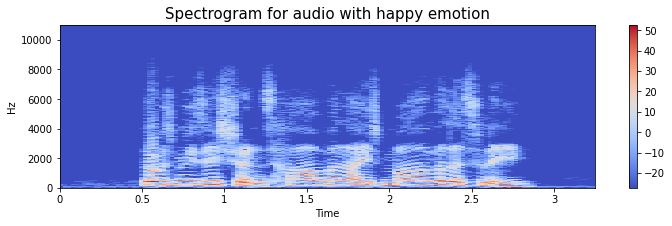

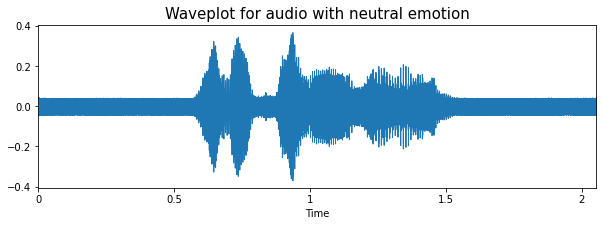

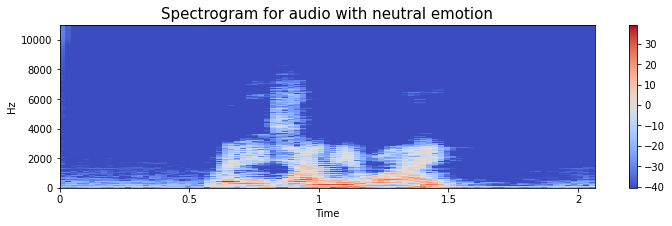

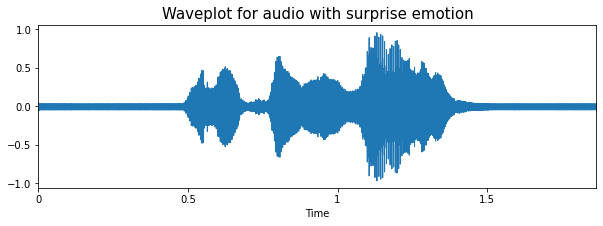

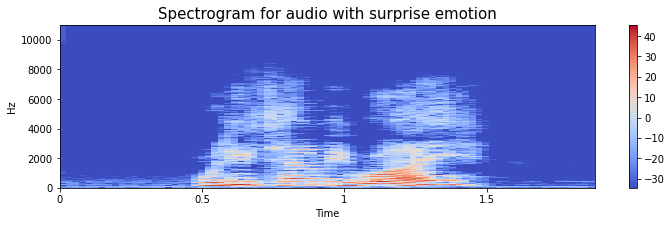

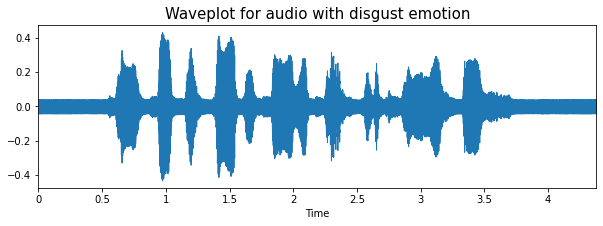

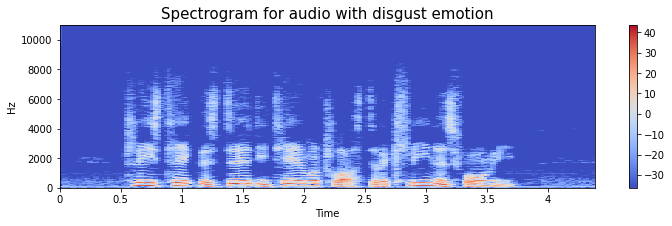

In [78]:
emotion_list=['fear','sad','angry','happy','neutral','surprise','disgust']
for emotion in emotion_list:
    path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)

In [79]:

#Data Augmentation
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

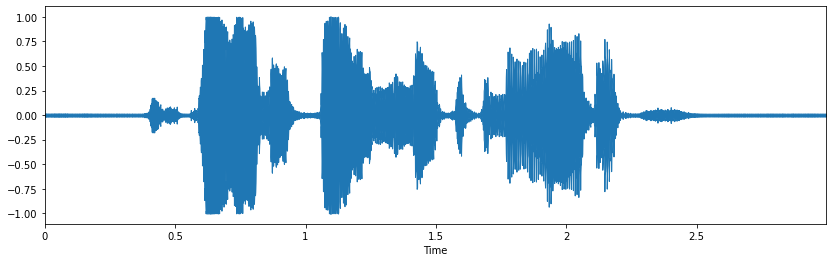

In [80]:
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)
#simple audio
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

In [81]:
#feature extraction
def extract_features(data):
    # ZCR
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = np.array([])

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=40).T, axis=0)
    result = mfcc # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [82]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = extract_features(path)
    for ele in feature:
        X.append(feature)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

KeyboardInterrupt: ignored

In [83]:
len(X), len(Y), data_path.Path.shape

(616, 616, (12162,))

In [2]:
# Features = pd.DataFrame(X)
# Features['labels'] = Y
# Features.to_csv('features1.csv', index=False)
Features=pd.read_csv('/content/features_mfcc.csv')
Features.head(10)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,labels
0,-268.60696,161.36963,2.625834,27.051480,9.680414,-1.744528,-39.217342,-5.714886,-1.228406,-17.096231,...,-2.792690,-1.645135,-2.903202,-1.860025,-1.266948,0.338842,2.045931,1.287455,-0.561106,angry
1,-268.60696,161.36963,2.625834,27.051480,9.680414,-1.744528,-39.217342,-5.714886,-1.228406,-17.096231,...,-2.792690,-1.645135,-2.903202,-1.860025,-1.266948,0.338842,2.045931,1.287455,-0.561106,angry
2,-268.60696,161.36963,2.625834,27.051480,9.680414,-1.744528,-39.217342,-5.714886,-1.228406,-17.096231,...,-2.792690,-1.645135,-2.903202,-1.860025,-1.266948,0.338842,2.045931,1.287455,-0.561106,angry
3,-276.74432,110.19599,-4.677224,17.128117,14.131120,-5.477931,-28.101225,-2.913490,-3.781958,-17.271315,...,1.988242,0.185391,-0.700379,1.297080,0.448868,0.237705,1.731720,2.902456,4.163277,angry
4,-276.74432,110.19599,-4.677224,17.128117,14.131120,-5.477931,-28.101225,-2.913490,-3.781958,-17.271315,...,1.988242,0.185391,-0.700379,1.297080,0.448868,0.237705,1.731720,2.902456,4.163277,angry
5,-276.74432,110.19599,-4.677224,17.128117,14.131120,-5.477931,-28.101225,-2.913490,-3.781958,-17.271315,...,1.988242,0.185391,-0.700379,1.297080,0.448868,0.237705,1.731720,2.902456,4.163277,angry
6,-266.07422,131.21901,-16.310183,15.545779,-1.886643,-12.010518,-23.761970,3.025579,-5.536036,-14.478219,...,2.163372,3.284388,2.875720,2.940749,3.583384,4.780197,7.402605,10.180189,10.285978,angry
7,-266.07422,131.21901,-16.310183,15.545779,-1.886643,-12.010518,-23.761970,3.025579,-5.536036,-14.478219,...,2.163372,3.284388,2.875720,2.940749,3.583384,4.780197,7.402605,10.180189,10.285978,angry
8,-266.07422,131.21901,-16.310183,15.545779,-1.886643,-12.010518,-23.761970,3.025579,-5.536036,-14.478219,...,2.163372,3.284388,2.875720,2.940749,3.583384,4.780197,7.402605,10.180189,10.285978,angry
9,-245.73842,148.37938,-6.686705,27.687923,0.520632,-6.821928,-34.225190,-6.423095,-3.465460,-19.676695,...,-0.160852,0.162248,1.073827,3.885853,6.795292,6.463089,8.563615,9.231743,6.398053,angry


In [3]:
Features.shape

(36486, 41)

In [7]:
X = Features.drop(['labels'], axis=1)
Y = Features['labels'].values

# As this is a multiclass classification problem onehotencoding our Y.

labels = {}
cnt = 0 
for i in Y:
	if i not in labels:
		labels[i] = cnt  
		cnt = cnt + 1 
for i in range(Y.shape[0]):
	Y[i] = labels[Y[i]]
arr = []

for k in labels.keys():
	arr.append(k)
np.save("labels.npy", np.array(arr))

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


#train test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=7,train_size=0.8, shuffle=True)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
[0 0 0 ... 0 0 0]
[0, 1, 2, 3, 4, 5, 6]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


((29188, 40), (29188, 7), (7298, 40), (7298, 7))

In [27]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((29188, 40), (29188, 7), (7298, 40), (7298, 7))

In [28]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((29188, 40, 1), (29188, 7), (7298, 40, 1), (7298, 7))

In [29]:

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 40, 256)           1536      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 20, 256)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 20, 256)           327936    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 10, 256)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 10, 128)           163968    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 5, 128)          

In [30]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0,min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp]) 

Epoch 1/50
457/457 [==============================] - 76s 164ms/step - loss: 1.5303 - accuracy: 0.3808 - val_loss: 1.2580 - val_accuracy: 0.5042 - lr: 0.0010
Epoch 2/50
457/457 [==============================] - 76s 167ms/step - loss: 1.2775 - accuracy: 0.4903 - val_loss: 1.1580 - val_accuracy: 0.5502 - lr: 0.0010
Epoch 3/50
457/457 [==============================] - 76s 166ms/step - loss: 1.1889 - accuracy: 0.5301 - val_loss: 1.1091 - val_accuracy: 0.5697 - lr: 0.0010
Epoch 4/50
457/457 [==============================] - 75s 163ms/step - loss: 1.1304 - accuracy: 0.5536 - val_loss: 1.0586 - val_accuracy: 0.5847 - lr: 0.0010
Epoch 5/50
457/457 [==============================] - 76s 167ms/step - loss: 1.0786 - accuracy: 0.5768 - val_loss: 1.0129 - val_accuracy: 0.6076 - lr: 0.0010
Epoch 6/50
457/457 [==============================] - 75s 164ms/step - loss: 1.0341 - accuracy: 0.5942 - val_loss: 0.9398 - val_accuracy: 0.6355 - lr: 0.0010
Epoch 7/50
457/457 [==============================] 

In [31]:
test_accuracy=model.evaluate(x_test,y_test,verbose=0)
print(test_accuracy[1])

0.9632776379585266


229/229 [==============================] - 3s 15ms/step - loss: 0.1682 - accuracy: 0.9633
Accuracy of our model on test data :  96.32776379585266 %


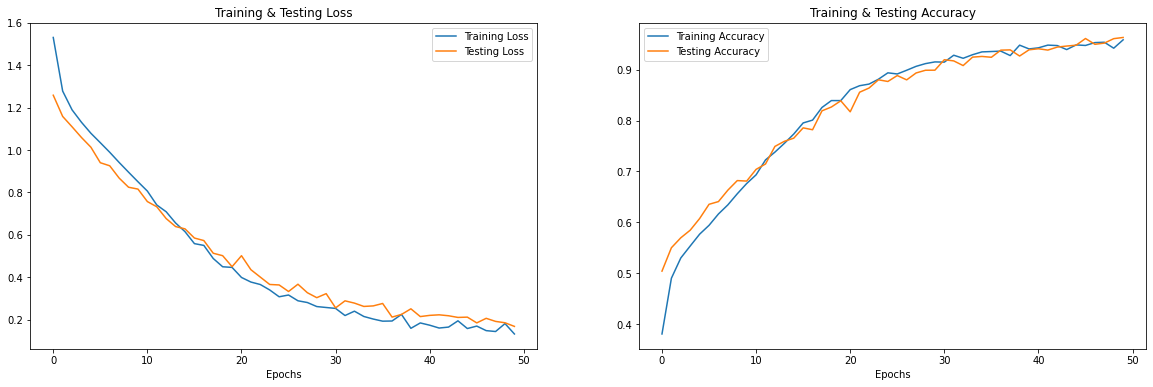

In [32]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [33]:
# # predicting on test data.
pred_test = model.predict(x_test,verbose=1)

229/229 [==============================] - 4s 15ms/step


In [34]:
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [35]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,happy,happy
2,angry,angry
3,neutral,neutral
4,surprise,surprise
5,disgust,disgust
6,sad,sad
7,fear,fear
8,fear,fear
9,fear,fear


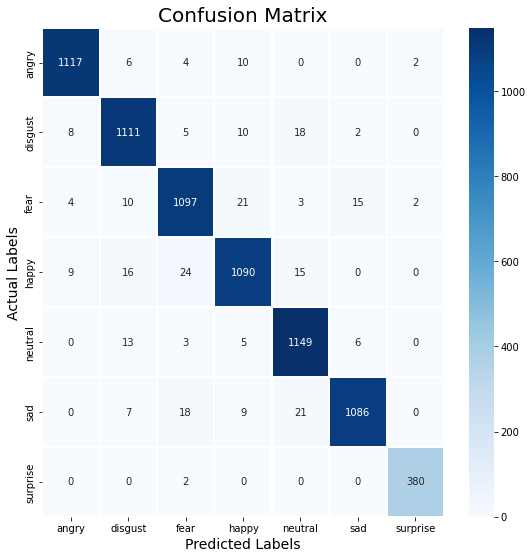

In [40]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (9, 9))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [41]:
model.save('model.h5')

In [44]:
from keras.models import load_model
model=load_model('/content/model.h5')

In [46]:
path = "/content/1001_DFA_FEA_XX.wav"
audio, sample_rate = librosa.load( path , duration=2.5,offset=0.6) 
mfcc =np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate,n_mfcc=40).T, axis=0)
mfcc_scaled_trans=scaler.transform(mfcc)
x = np.expand_dims(mfcc, axis=1)
pred = model.predict(x)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


ValueError: ignored